# AI-Powered Emotion Detection from Text

This notebook implements an AI model for detecting emotions from text. 
It combines two datasets, preprocesses the text, extracts features, trains a model, and evaluates its performance.

##### The two datasets are:

1. Google Go Emotions Dataset [https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset]

2. Twitter Emotions Dataset [https://www.kaggle.com/datasets/adhamelkomy/twitter-emotion-dataset]

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEVANSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEVANSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DEVANSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DEVANSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Data Collection & Merging

We load two datasets:
1. `dataset1` (text.csv): Contains text mapped to integer labels (0-5).
2. `dataset2` (go_emotions_dataset.csv): Contains text with multi-label one-hot encoded emotions.

We will combine these into a single format: `text` and `emotion`.

In [2]:
try:
    df1 = pd.read_csv('text.csv')
    df2 = pd.read_csv('go_emotions_dataset.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset files not found. Please ensure 'text.csv' and 'go_emotions_dataset.csv' are in the directory.")

print("Processing Dataset 1...")
label_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
if 'label' in df1.columns:
    df1['emotion'] = df1['label'].map(label_map)
    df1 = df1[['text', 'emotion']]

print("Processing Dataset 2...")
if 'example_very_unclear' in df2.columns:
    df2 = df2[df2['example_very_unclear'] == False]

non_emotion_cols = ['id', 'text', 'example_very_unclear']
emotion_cols = [c for c in df2.columns if c not in non_emotion_cols]

# Converting one-hot to single label using idxmax
df2['emotion'] = df2[emotion_cols].idxmax(axis=1)
df2 = df2[['text', 'emotion']]

print("Merging datasets...")
df = pd.concat([df1, df2], axis=0, ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

initial_len = len(df)
df.dropna(subset=['text', 'emotion'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
print(f"Dropped {initial_len - len(df)} rows (duplicates/nulls).")
print(f"Final Dataset Shape: {df.shape}")
print(df['emotion'].value_counts().head())

Datasets loaded successfully.
Processing Dataset 1...
Processing Dataset 2...
Merging datasets...
Dropped 173071 rows (duplicates/nulls).
Final Dataset Shape: (451552, 2)
emotion
joy        136392
sadness    119470
anger       56934
fear        44353
love        30998
Name: count, dtype: int64


## 2. Preprocessing

A standard NLP preprocessing pipeline is implemented:
- Lowercasing
- Removing special characters
- Tokenization
- Stopword removal
- Lemmatization

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = nltk.word_tokenize(text)
    
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(cleaned_tokens)

print("Preprocessing text (this may take a few minutes for large datasets)...")
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")

Preprocessing text (this may take a few minutes for large datasets)...
Preprocessing complete.


## 3. Feature Extraction
Converting text to TF-IDF vectors.

In [5]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['emotion']
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (451552, 5000)


## 4. Model Training
We use Logistic Regression for multi-class classification.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, multi_class='ovr')
print("Training model...")
model.fit(X_train, y_train)
print("Training complete.")

Training model...


C:\Users\DEVANSHI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete.


## 5. Evaluation
Analyzing Accuracy, F1-Score, and Confusion Matrix.

Accuracy: 0.8556
F1 Score: 0.8418


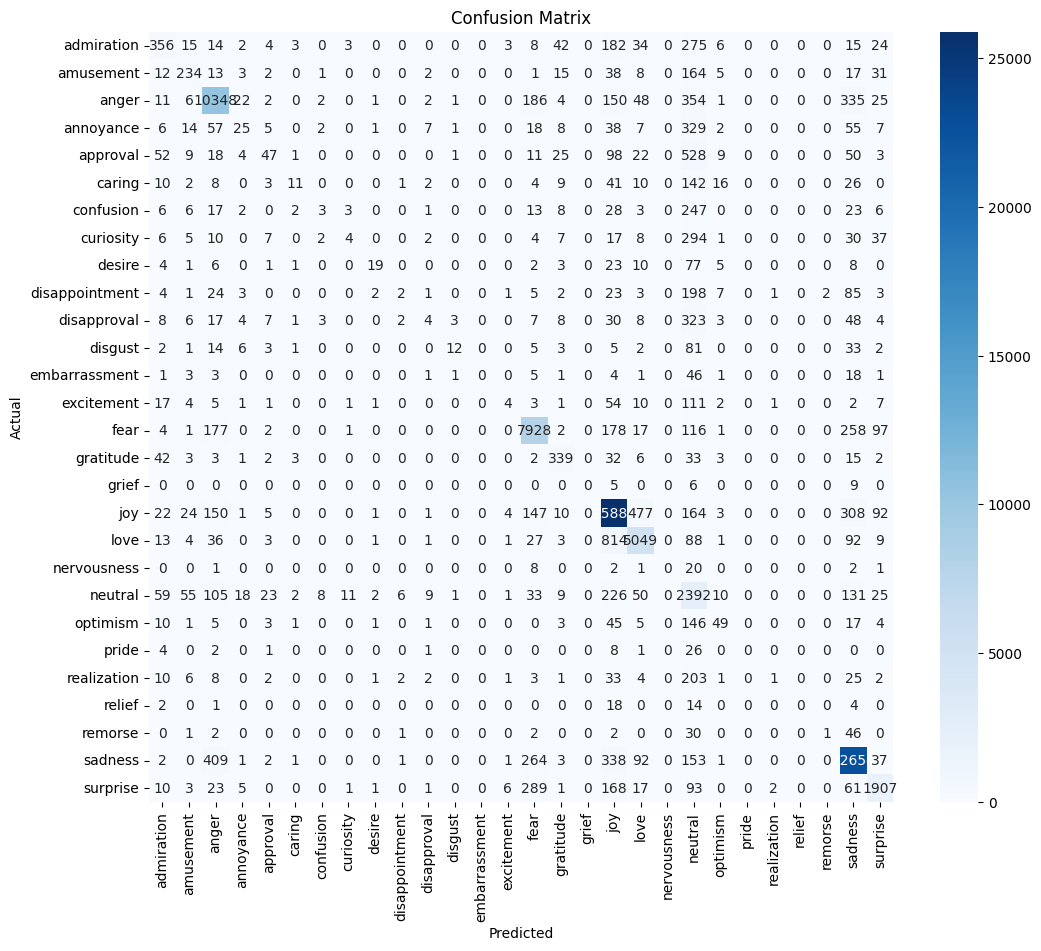

In [7]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
# We need class labels for the plot
labels = sorted(df['emotion'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 6. Real-World Application & Testing
Function to predict emotion on new text.

In [8]:
def predict_new_text(user_input):
    processed = preprocess_text(user_input)
    vectorized = tfidf.transform([processed])
    prediction = model.predict(vectorized)[0]
    return prediction

# Test custom examples
examples = [
    "I am feeling so great today!",
    "This is absolutely terrible news.",
    "I'm scared of the dark.",
    "I love this project!",
    "I am confused about what to do next."
]

for ex in examples:
    print(f"Input: '{ex}' -> Predicted: {predict_new_text(ex)}")

Input: 'I am feeling so great today!' -> Predicted: joy
Input: 'This is absolutely terrible news.' -> Predicted: sadness
Input: 'I'm scared of the dark.' -> Predicted: fear
Input: 'I love this project!' -> Predicted: love
Input: 'I am confused about what to do next.' -> Predicted: fear
